In [23]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import os 
import sys
import glob
import scipy.misc as spm
import json
import pprint
import pandas as pd
from PIL import Image
from sklearn.feature_extraction.image import extract_patches_2d
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [24]:
train_data = pd.read_csv('../data/validation/train.csv')

img_03596.jpg
YFT


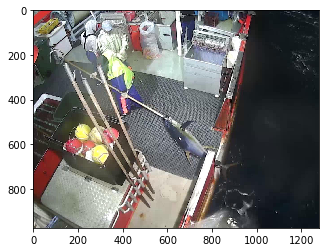

In [25]:
example = train_data.iloc[0]
print example.filename
print example.label

filename = '../data/train/{}/{}'.format(example.label, example.filename)
image = spm.imread(filename)
plt.imshow(image)
plt.show()

In [26]:
data = open('../data/bounding_boxes/{}_labels.json'.format(example.label.lower()))
bb = json.load(data)
patch_width = 128
patch_height = 128
nb_epoch = 10
print image.shape

(974L, 1280L, 3L)


In [27]:
from collections import defaultdict
sum_width = 0
sum_height = 0

bboxes = defaultdict(list)

for img in bb:
    for annot in img['annotations']:
        sum_width +=  annot['width']
        sum_height +=  annot['height']
        bboxes[img['filename']].append((annot['x'], annot['y'], annot['width'], annot['height']))

        
        

In [28]:
def get_patches(bbox, amount= 1):
    return extract_patches_2d(bbox, patch_size=(patch_height,patch_width), max_patches=5, random_state=None)


In [37]:
X_train = []
y_train = []
X_test = []
y_test = []

for k,v in bboxes.iteritems():
    image = spm.imread(k)
    box = v[0]
    x = int(round(box[0]))
    y = int(round(box[1]))
    width = int(round(box[2]))
    height = int(round(box[3]))
    if width < patch_width or height < patch_height:
        continue
    bbox_fish = image[y:y+height,x:x+width,:]
    
    if(x+0.5*width>image.shape[1]/2):
        bbox_rnd = image[:y,:x,:]
    else:
        bbox_rnd = image[y+height:,x+width:,:]
    if bbox_rnd.shape[0] < patch_height:
        continue
    
    patches_fish = get_patches(bbox_fish,amount=5)
    patches_rnd = get_patches(bbox_rnd,amount=5)
    
    count = 1
    for p1,p2 in zip(patches_fish,patches_rnd):
        p1 = spm.imresize(p1,size=(64,64)).transpose(2,0,1)
        p2 = spm.imresize(p2,size=(64,64)).transpose(2,0,1)
        if count < len(patches_fish):
            X_train.append(p1)
            y_train.append(1)
            X_train.append(p2)
            y_train.append(0)
        else:
            X_test.append(p1)
            y_test.append(1)
            X_test.append(p2)
            y_test.append(0)
        count +=1
            
            
X_train = np.array(X_train).astype('float32') /255
y_train = np.array(y_train)
X_test = np.array(X_test).astype('float32') /255
y_test = np.array(y_test)


print X_train.shape
print y_train.shape
print X_test.shape
print y_test.shape


(3640L, 3L, 64L, 64L)
(3640L,)
(910L, 3L, 64L, 64L)
(910L,)


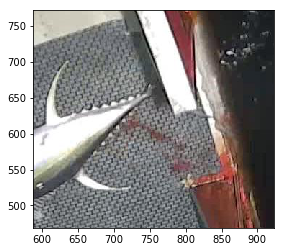

In [38]:
# Example how to extract the good labels
# Only using the first index, should become the largest??
height, width, co_x, co_y = None, None, None, None
with open('../data/bounding_boxes/{}_labels.json'.format(example.label.lower())) as data_file:
    data = json.load(data_file)
    for i in range(len(data)):
        path = '../data/train/{}/{}'.format(example.label, example.filename)
        if data[i]['filename'] == path:
            height = data[i]['annotations'][0]['height']
            width = data[i]['annotations'][0]['width']
            co_x = data[i]['annotations'][0]['x']
            co_y = data[i]['annotations'][0]['y']

fig, ax = plt.subplots(1)
ax.imshow(image)
plt.xlim(co_x, co_x+width)
plt.ylim(co_y, co_y+height)
plt.show()

In [39]:
# for img, i in zip(X_train,y_train):
#     if i == 0:
#         plt.imshow(img.transpose(1,2,0))
#         plt.show()

In [45]:
def keras_model_conv2():
  from keras.models import Sequential
  from keras.layers import Dense, Dropout, Activation,Flatten
  from keras.layers import Convolution2D, MaxPooling2D
  from keras.optimizers import SGD
  model = Sequential()
  model.add(Convolution2D(16, 5, 5, 
                          border_mode='valid', 
                          input_shape=(3, 64, 64)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(32, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Convolution2D(64, 3, 3))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2,2))) 
  print model.layers[-1].output_shape  
  model.add(Convolution2D(512, 6,6))
  model.add(Activation('relu'))
  model.add(Convolution2D(256, 1, 1))
  model.add(Activation('relu'))
  model.add(Convolution2D(1, 1, 1))
  model.add(Flatten())
  model.add(Activation('sigmoid'))

    
  model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
  return model

In [46]:
model_path = r'C:\Users\Thomas\Documents\MLIP-BigAITuna\model\bounding_boxes.h5'
model = keras_model_conv2()
if os.path.exists(model_path):
    model.load_weights(model_path)


(None, 64, 6, 6)


In [47]:
datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=10,
                             zoom_range=[0.8, 1.2],
                             width_shift_range=0.1,
                             height_shift_range=0.1)
train_gen = datagen.flow(X_train, 
                         y_train)
val_gen = ImageDataGenerator().flow(X_test, y_test)
    

In [49]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.9)
checkpoint = ModelCheckpoint(filepath='C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.{epoch:02d}-{loss}.hdf5', verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(X_train),
                    nb_epoch=30, verbose=2,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(X_test))

model.save_weights(model_path)

Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.26495, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.00-0.197993306766.hdf5
8s - loss: 0.1980 - acc: 0.9168 - val_loss: 0.2650 - val_acc: 0.8802
Epoch 2/30
Epoch 00001: val_loss improved from 0.26495 to 0.21239, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.01-0.216977751779.hdf5
8s - loss: 0.2170 - acc: 0.9093 - val_loss: 0.2124 - val_acc: 0.9176
Epoch 3/30
Epoch 00002: val_loss did not improve
8s - loss: 0.2022 - acc: 0.9140 - val_loss: 0.2162 - val_acc: 0.9132
Epoch 4/30
Epoch 00003: val_loss improved from 0.21239 to 0.20730, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.03-0.187345244367.hdf5
8s - loss: 0.1873 - acc: 0.9258 - val_loss: 0.2073 - val_acc: 0.9077
Epoch 5/30
Epoch 00004: val_loss improved from 0.20730 to 0.19178, saving model to C:/Users/Thomas/Documents/MLIP-BigAITuna/logging/model.04-0.17759637646.hdf5
8s - loss: 0.1776 - acc: 0.9272 - va